In [11]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.initializers import normal

import os

from statsmodels.tsa.arima_model import ARIMA
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import matplotlib.ticker as mticker


import datetime
from datetime import datetime,timedelta
import time
from matplotlib.dates import date2num
from pandas.tseries.offsets import Day,MonthEnd
from pandas.tseries.offsets import Hour

import warnings
warnings.filterwarnings('ignore')

yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx


import seaborn as sns

from sklearn.decomposition import PCA

import math
from numpy.fft import *

import matplotlib.dates as dates
import matplotlib.ticker as mticker

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score


import re 

In [12]:
def download(ticker,start,end,df): ## downloads the stock data from internet
    try:
        df=pdr.get_data_yahoo(ticker,start,end)
    except ValueError:
        pass
    return df

def to_supervised(df,n_in,n_out): ## transforms the dataframe to t-(n_in) values and adds the target in time t
    n_vars=prices.shape[1]
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    df=agg
    for i in range(n_in):
        df=df.rename (columns= {"var1(t-{})".format(i+1): "Open(t-{})".format(i+1), 
                                  "var2(t-{})".format(i+1):"High(t-{})".format(i+1), 
                                  "var3(t-{})".format(i+1): "Low(t-{})".format(i+1),
                                  "var4(t-{})".format(i+1): "Close(t-{})".format(i+1),
                                  "var5(t-{})".format(i+1): "Volume(t-{})".format(i+1),
                                  #"var4(t)": "Close(t)",
                                   })
    if(n_out==1):
        df=df.rename (columns= {"var4(t)": "Close(t)"})
        df.drop(['var1(t)','var2(t)','var3(t)','var5(t)'],axis=1,inplace=True)
    else:
        df.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)'],axis=1,inplace=True)
        df=df.rename (columns= {"var4(t+{})".format(n_out-1): "Close(t+{})".format(n_out-1)})
        for i in range(n_out-1):
            if((i+1)!=n_out-1):
                df.drop(['var1(t+{})'.format(i+1),'var2(t+{})'.format(i+1),'var3(t+{})'.format(i+1),
                        'var4(t+{})'.format(i+1),'var5(t+{})'.format(i+1)],axis=1,inplace=True)
            else:
                df.drop(['var1(t+{})'.format(i+1),'var2(t+{})'.format(i+1),'var3(t+{})'.format(i+1),
                        'var5(t+{})'.format(i+1)],axis=1,inplace=True)
                
    return df

def transform_features(df):
    # reshape input to be [samples, time steps, features]
    #passing data as features
    
    df.drop(['GS_Close(t)'],axis=1,inplace=True) 
    df.drop(['GS_High(t-1)','GS_Low(t-1)'],axis=1,inplace=True)

    
    df=np.array(df)
    x_train=df[:len(df)-365,:-1]
    y_train=df[:len(df)-365,-1]

    Xtest=df[len(df)-365:,:-1]
    ytest=df[len(df)-365:,-1]

    y_train=y_train.reshape(-1,1)
    ytest=ytest.reshape(-1,1)

    scaler_x = MinMaxScaler()
    scaler_x.fit(x_train)
    x_train=scaler_x.transform(x_train)
    Xtest=scaler_x.transform(Xtest)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_train)
    y_train=scaler_y.transform(y_train)
    ytest=scaler_y.transform(ytest)


    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
    return(x_train,y_train,Xtest,ytest,scaler_x,scaler_y)

def transform_timesteps(df):
    # reshape input to be [samples, time steps, features]
    #passing data as timesteps
    
    df.drop(['GS_Close(t)'],axis=1,inplace=True)
    df.drop(['GS_High(t-1)','GS_Low(t-1)'],axis=1,inplace=True)

    df=np.array(df)
    x_train=df[:len(df)-365,:-1]
    y_train=df[:len(df)-365,-1]

    Xtest=df[len(df)-365:,:-1]
    ytest=df[len(df)-365:,-1]

    y_train=y_train.reshape(-1,1)
    ytest=ytest.reshape(-1,1)

    scaler_x = MinMaxScaler()
    scaler_x.fit(x_train)
    x_train=scaler_x.transform(x_train)
    Xtest=scaler_x.transform(Xtest)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_train)
    y_train=scaler_y.transform(y_train)
    ytest=scaler_y.transform(ytest)


    x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
    Xtest = Xtest.reshape((Xtest.shape[0],Xtest.shape[1],1))
    return(x_train,y_train,Xtest,ytest,scaler_x,scaler_y)

def MSE(actual,prediction):## Mean squared error function
    return np.sum((actual-prediction)**2)/len(actual)

def direction_gain(for_metric,open_price,all_predictions,actual_direction):
    gain=[]
    for i,j,k,l in zip(all_predictions,actual_direction,for_metric,open_price):
        if i==j:
            gain.append(np.abs(k-l))
        if i!=j:
            if j==0:
                gain.append(l-k)
            if j==1:
                gain.append(k-l)  
    return gain
            
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['GS_Close(t-1)'].rolling(window=7).mean()
    dataset['ma21'] = dataset['GS_Close(t-1)'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['GS_Close(t-1)'].ewm(span=26).mean()
    dataset['12ema'] = dataset['GS_Close(t-1)'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['GS_Close(t-1)'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['GS_Close(t-1)'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['GS_Close(t-1)']-1
    
    
    return dataset

def filter_signal10(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=10e-3/signal.size)  #change the number to change the plot
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def filter_signal20(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=30e-3/signal.size)  #change the number to change the plot
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def filter_signal30(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)  #change the number to change the plot
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [13]:
prices=pd.read_csv("all_stocks/GS.csv")
n_in=1
n_out=1
prices.drop(['Date'],axis=1,inplace=True)
prices=to_supervised(prices,n_in,n_out)
names=[]
for i in prices.columns:
    names.append('GS_{}'.format(i))
prices.columns=names
prices.head()

extra=pd.read_csv("all_stocks/^IXIC.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"^IXIC_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/^VIX.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"^VIX_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/BAC.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"BAC_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/BCS.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"BCS_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/CS.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"CS_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/JPM.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"JPM_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/MS.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"MS_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/HSI.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"HSI_Close"} )

prices=prices.join(extra)
prices['HSI_Close']=prices['HSI_Close'].shift(9)

extra=pd.read_csv("all_stocks/NYA.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"NYA_Close"} )
prices=prices.join(extra)
prices['NYA_Close']=prices['NYA_Close'].shift(149)

extra=pd.read_csv("all_stocks/^N225.csv")
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"^N225_Close"} )
prices=prices.join(extra)
prices['^N225_Close']=prices['^N225_Close'].shift(25)

prices=get_technical_indicators(prices)

fourier=filter_signal10(prices['GS_Close(t-1)'])
fourier=pd.DataFrame(fourier)
fourier=fourier.rename(columns={0:'fourier10'})
prices=prices.join(fourier)
prices['fourier10']=prices['fourier10'].shift(2)

fourier=filter_signal20(prices['GS_Close(t-1)'])
fourier=pd.DataFrame(fourier)
fourier=fourier.rename(columns={0:'fourier20'})
prices=prices.join(fourier)
prices['fourier20']=prices['fourier20'].shift(2)

fourier=filter_signal30(prices['GS_Close(t-1)'])
fourier=pd.DataFrame(fourier)
fourier=fourier.rename(columns={0:'fourier30'})
prices=prices.join(fourier)
prices['fourier30']=prices['fourier30'].shift(2)

prices=prices.shift(-149).dropna()

In [14]:
for_metric=prices['GS_Close(t)']
for_metric.drop(1,inplace=True)
starting=prices['GS_Open(t-1)'].shift(-1).dropna()
prices['direction']=1.0
prices['direction'][prices['GS_Close(t-1)']>prices['GS_Close(t)']]=0.0
direction=prices['direction']
prices.drop(['direction'],axis=1,inplace=True)
prices=prices.pct_change()
prices['direction']=direction
prices[prices>0]=1
prices[prices<0]=0
prices=prices.dropna()

In [15]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_timesteps(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(80, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),activation='tanh'))
model_lstm.add(layers.Dense(1,activation='sigmoid'))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='binary_crossentropy', optimizer=opt)


In [16]:
model_lstm.load_weights('classification_lstm_2.hdf5')
trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)
all_predictions_f[all_predictions_f>0.5]=1
all_predictions_f[all_predictions_f<0.5]=0

In [17]:
gainz=direction_gain(for_metric,starting,all_predictions_f,direction)
print("Gain for train and test :",np.sum(gainz))
print("Gain for test only:",np.sum(gainz[544:]))

Gain for train and test : 1669.4200519999997
Gain for test only: 818.1800089999999


In [18]:
for_plotting=pd.DataFrame(for_metric)
for_plotting['prediction']=all_predictions_f
for_plotting['direction']=prices['direction']


In [19]:
pos_plot=for_plotting['GS_Close(t)'][for_plotting['direction']==for_plotting['prediction']]
pos_plot=pos_plot.T
for i in range(1000):
    if i not in pos_plot.index:
        pos_plot[i]=np.nan
        
pos_plot=pos_plot.sort_index()

neg_plot=for_plotting['GS_Close(t)'][for_plotting['direction']!=for_plotting['prediction']]
neg_plot=neg_plot.T
for i in range(1000):
    if i not in neg_plot.index:
        neg_plot[i]=np.nan
        
neg_plot=neg_plot.sort_index()

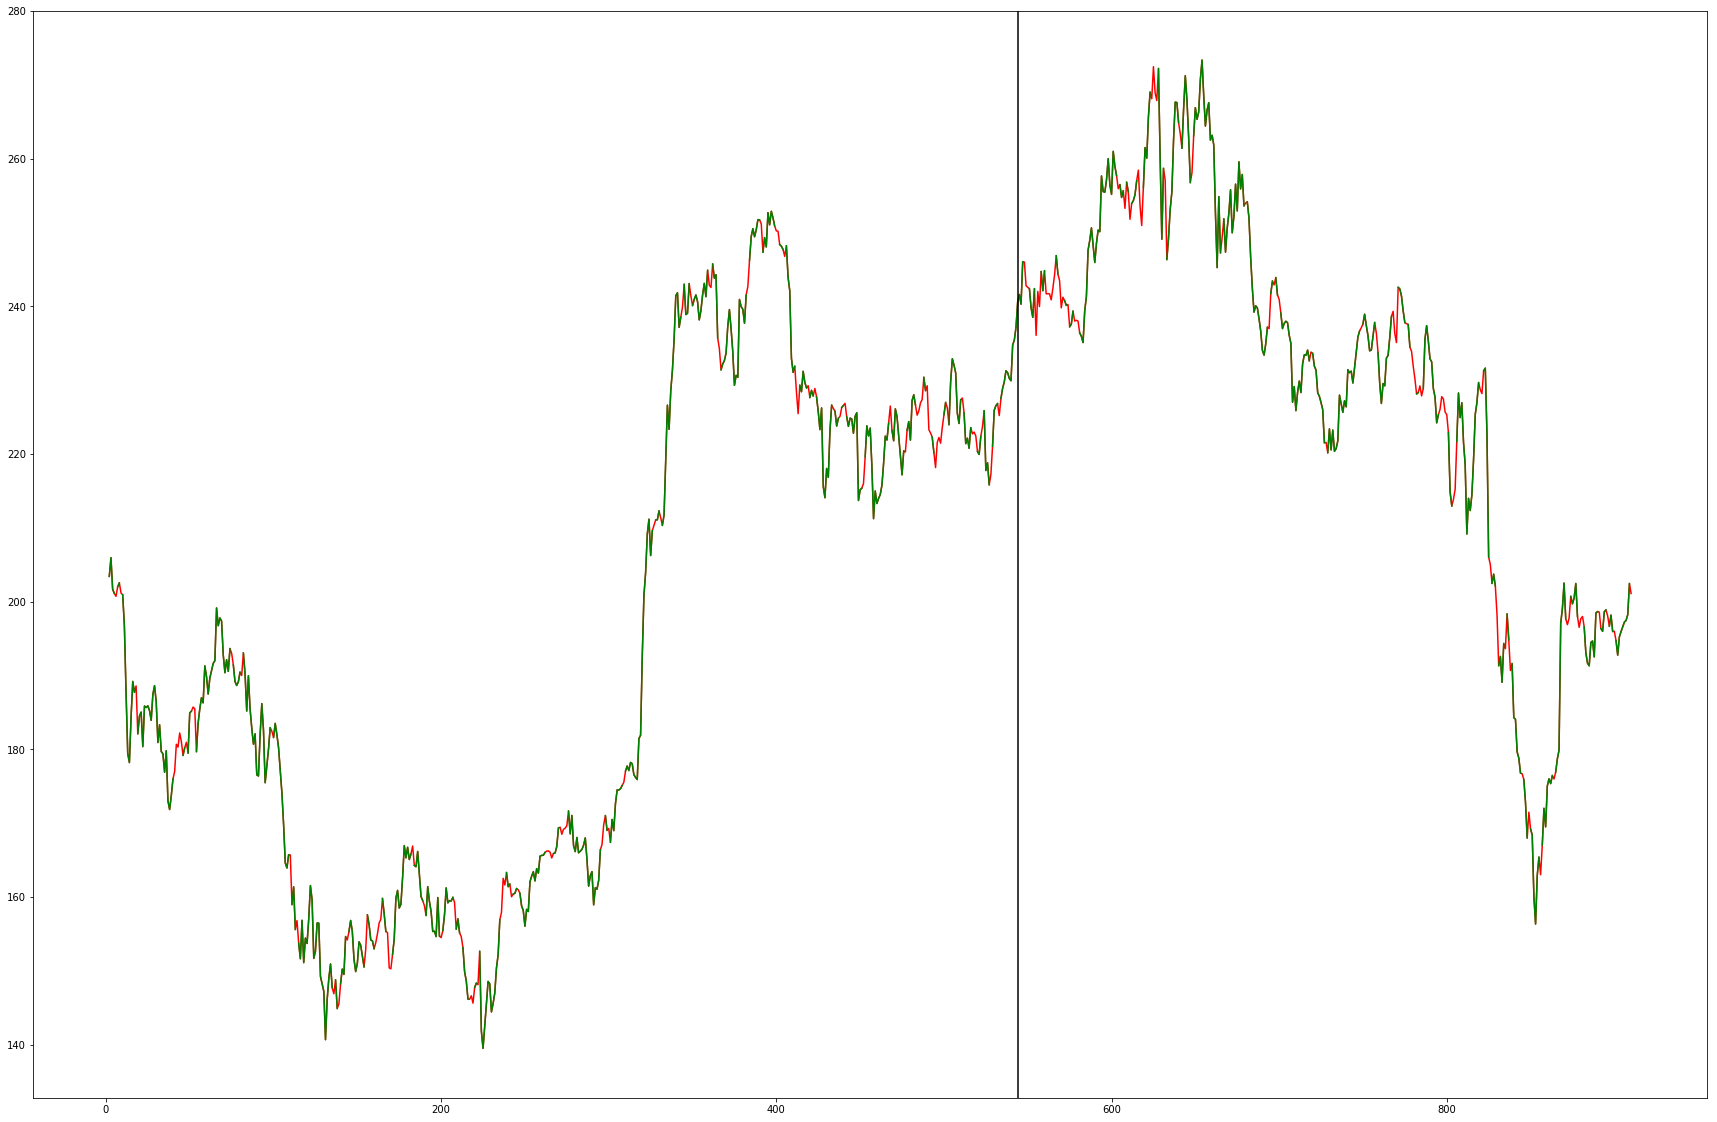

In [20]:
plt.figure(figsize=(30,20))
plt.plot(for_plotting['GS_Close(t)'],'r')
plt.plot(pos_plot,'g')
plt.axvline(x=544,color='k')

In [29]:
#accuracy of the days that we predicted right
gain_acc = pd.DataFrame(gainz[544:])
right_days = gain_acc[gain_acc>0].count()
accuracy = right_days/len(gain_acc)
accuracy

0    0.736986
dtype: float64

In [36]:
#the gain of the stock at the time of testing
np.abs(starting[544]-starting[909])

38.020004